# Quora Analysis with Logistic Regression

![](http://www.sociobits.org/wp-content/uploads/2015/02/Quora.jpg)

## Quora Insincere Questions Classification


Quora is a platform as wikipedia, where the knowledge is shared to everyone. On Quora, people can ask questions and others can reply with quality answers.  

This is the second time that Quora launch a competition on Kaggle and the goal now is to weed out insincere questions, those founded upon false premises, or that intend to make a statement rather than look for helpful answers.Quora wants to handle toxic content and to tackle this problem has launched a challenge to develop models that identify and flag insincere questions. 
The evaluation metric used to evaluate the goodness of fit between the predicted and the observed targets is 
F1 score.

F1 score or F score is a metric for accuracy used for binary classification task: 

https://en.wikipedia.org/wiki/F1_score

https://stackoverflow.com/questions/45963174/what-is-f1-score-and-what-its-value-indicates

It gathers precision and recall, the first one is the proportion of true positive on all positives predictions, the second one is the proportion of true positives on all actual positive elements.
In a binary classification you can have 4 results:

-true positive: correctly assigned as positive.

-true negative: correctly assigned as negative.

-false positive: wrongly assigned as positive.

-false negative: wrongly assigned as negative.

So precision is the ratio: true positive / (true positive + false positive).
Recall is the ratio: true positive / (true positive + false negative).

F1 score is the harmonic mean of the precision and recall (harmonic mean because the precision and recall are ratios):
F1 = 2 * (Precision * Recall)/(Precision + Recall)


## Tutorials 

https://www.kaggle.com/sudalairajkumar/simple-exploration-notebook-qiqc

https://www.kaggle.com/tunguz/just-some-simple-eda

https://www.kaggle.com/mjbahmani/a-data-science-framework-for-quora

https://www.kaggle.com/aashita/word-clouds-of-various-shapes 

https://hub.packtpub.com/use-tensorflow-and-nlp-to-detect-duplicate-quora-questions-tutorial/

# Content

- <a href='#1'>1. Loading Packages and Data</a>
- <a href='#2'>2. Glimpse of Data</a>
- <a href='#3'>3. Data Exploration</a>
  - <a href='#3-1'>3.1 Target Analysis</a>
  - <a href='#3-2'>3.2 Data Analysis</a>
- <a href='#4'>4. Feature Engineering</a>
  - <a href='#4-1'>4.1 TF-IDF and SVD features</a>
  - <a href='#4-2'>4.2 Word2Vec Embeddings</a>
- <a href='#5'>5. Logistic regression Baseline Model</a>


# <a href='#1'>1. Loading Packages and Data</a>

In [1]:
# load libraries
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk import word_tokenize
import os
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from copy import deepcopy
from sklearn.decomposition import TruncatedSVD
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from scipy import sparse
from scipy.stats import skew, kurtosis
from scipy.spatial.distance import cosine, cityblock, jaccard, canberra, euclidean, minkowski, braycurtis
import gensim
import gc

[nltk_data] Downloading package punkt to /home/claudio/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/claudio/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
import plotly
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.offline as py
from plotly import tools
py.init_notebook_mode(connected=True)
from os import path
from wordcloud import WordCloud,STOPWORDS,ImageColorGenerator
import seaborn as sns
from collections import defaultdict
%matplotlib inline

In [3]:
# load dataset
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

# <a href='#2'>2. Glimpse of Data</a>

In [4]:
train.head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


In [5]:
test.head()

,qid,question_text
0,00014894849d00ba98a9,My voice range is A2-C5. My chest voice goes u...
1,000156468431f09b3cae,How much does a tutor earn in Bangalore?
2,000227734433360e1aae,What are the best made pocket knives under $20...
3,0005e06fbe3045bd2a92,Why would they add a hypothetical scenario tha...
4,00068a0f7f41f50fc399,What is the dresscode for Techmahindra freshers?


In [6]:
print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1306122 entries, 0 to 1306121
Data columns (total 3 columns):
qid              1306122 non-null object
question_text    1306122 non-null object
target           1306122 non-null int64
dtypes: int64(1), object(2)
memory usage: 29.9+ MB
None


In [7]:
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56370 entries, 0 to 56369
Data columns (total 2 columns):
qid              56370 non-null object
question_text    56370 non-null object
dtypes: object(2)
memory usage: 880.9+ KB
None


In [8]:
train.shape

(1306122, 3)

In [9]:
test.shape

(56370, 2)

In [10]:
train.columns

Index(['qid', 'question_text', 'target'], dtype='object')

In [11]:
test.columns

Index(['qid', 'question_text'], dtype='object')

In [12]:
train.isnull().sum()

qid              0
question_text    0
target           0
dtype: int64

In [13]:
test.isnull().sum()

qid              0
question_text    0
dtype: int64

# <a href='#3'>3. Data Exploration</a>

## <a href='#3-1'>3.1 Target Analysis</a>

Bar-plot of the target variable shows an imbalanced distribution of the data between the classes of questions.
In these situations you can overcome it with these methods:

collecting more data;

resambpling dataset (oversampling or undersampling);

generating synthetic samples;

trying different algorithms;

using penalized models;

trying different perspectives (anomaly detection or change detection)




In [14]:
train_target = train['target'].values
np.unique(train_target)

array([0, 1])

In [15]:
train_target.mean()

0.06187017751787352

In [16]:
train.describe() 

,target
count,1.306122e+06
mean,6.187018e-02
std,2.409197e-01
min,0.000000e+00
25%,0.000000e+00
50%,0.000000e+00
75%,0.000000e+00
max,1.000000e+00


In [17]:
## target count ##
cnt_target = train['target'].value_counts()
count = go.Bar(
    x=cnt_target.index,
    y=cnt_target.values,
    marker=dict(
        color=cnt_target.values,
        colorscale = 'Viridis',
        reversescale = True
    ),
)

layout = go.Layout(
    title='Target Count',
    font=dict(size=18))

data = [count]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="TargetCount")

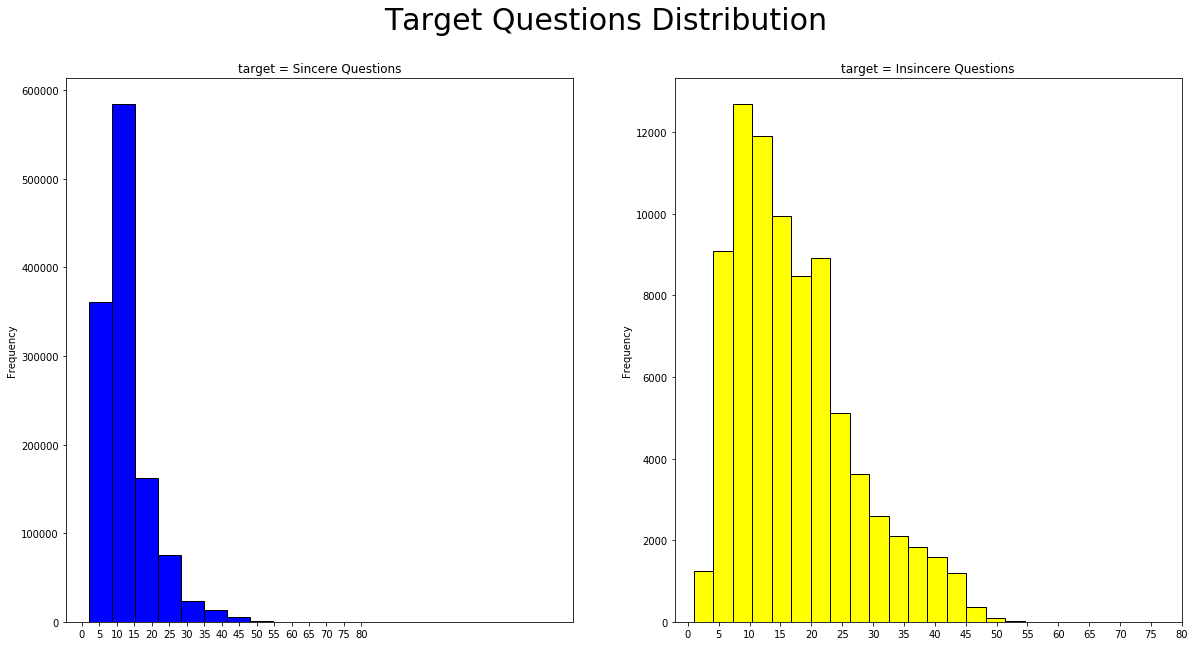

In [18]:
# Distributions
f,ax=plt.subplots(1,2,figsize=(20,10))
train[train['target']==0].question_text.apply(lambda x: len(str(x).split())).plot.hist(ax=ax[0],
                                                        bins=20,edgecolor='black',color='blue')
ax[0].set_title('target = Sincere Questions')
x1=list(range(0,85,5))
ax[0].set_xticks(x1)
train[train['target']==1].question_text.apply(lambda x: len(str(x).split())).plot.hist(ax=ax[1],color='yellow',
                                                                                     bins=20,edgecolor='black')
ax[1].set_title('target = Insincere Questions')
x2=list(range(0,85,5))
ax[1].set_xticks(x2)
plt.suptitle("Target Questions Distribution", fontsize=30)
plt.show()

## <a href='#3-2'>3.2 Data Analysis</a>

Word frequency plot shows that some top words are common in both classes: "people","one","good","know",...

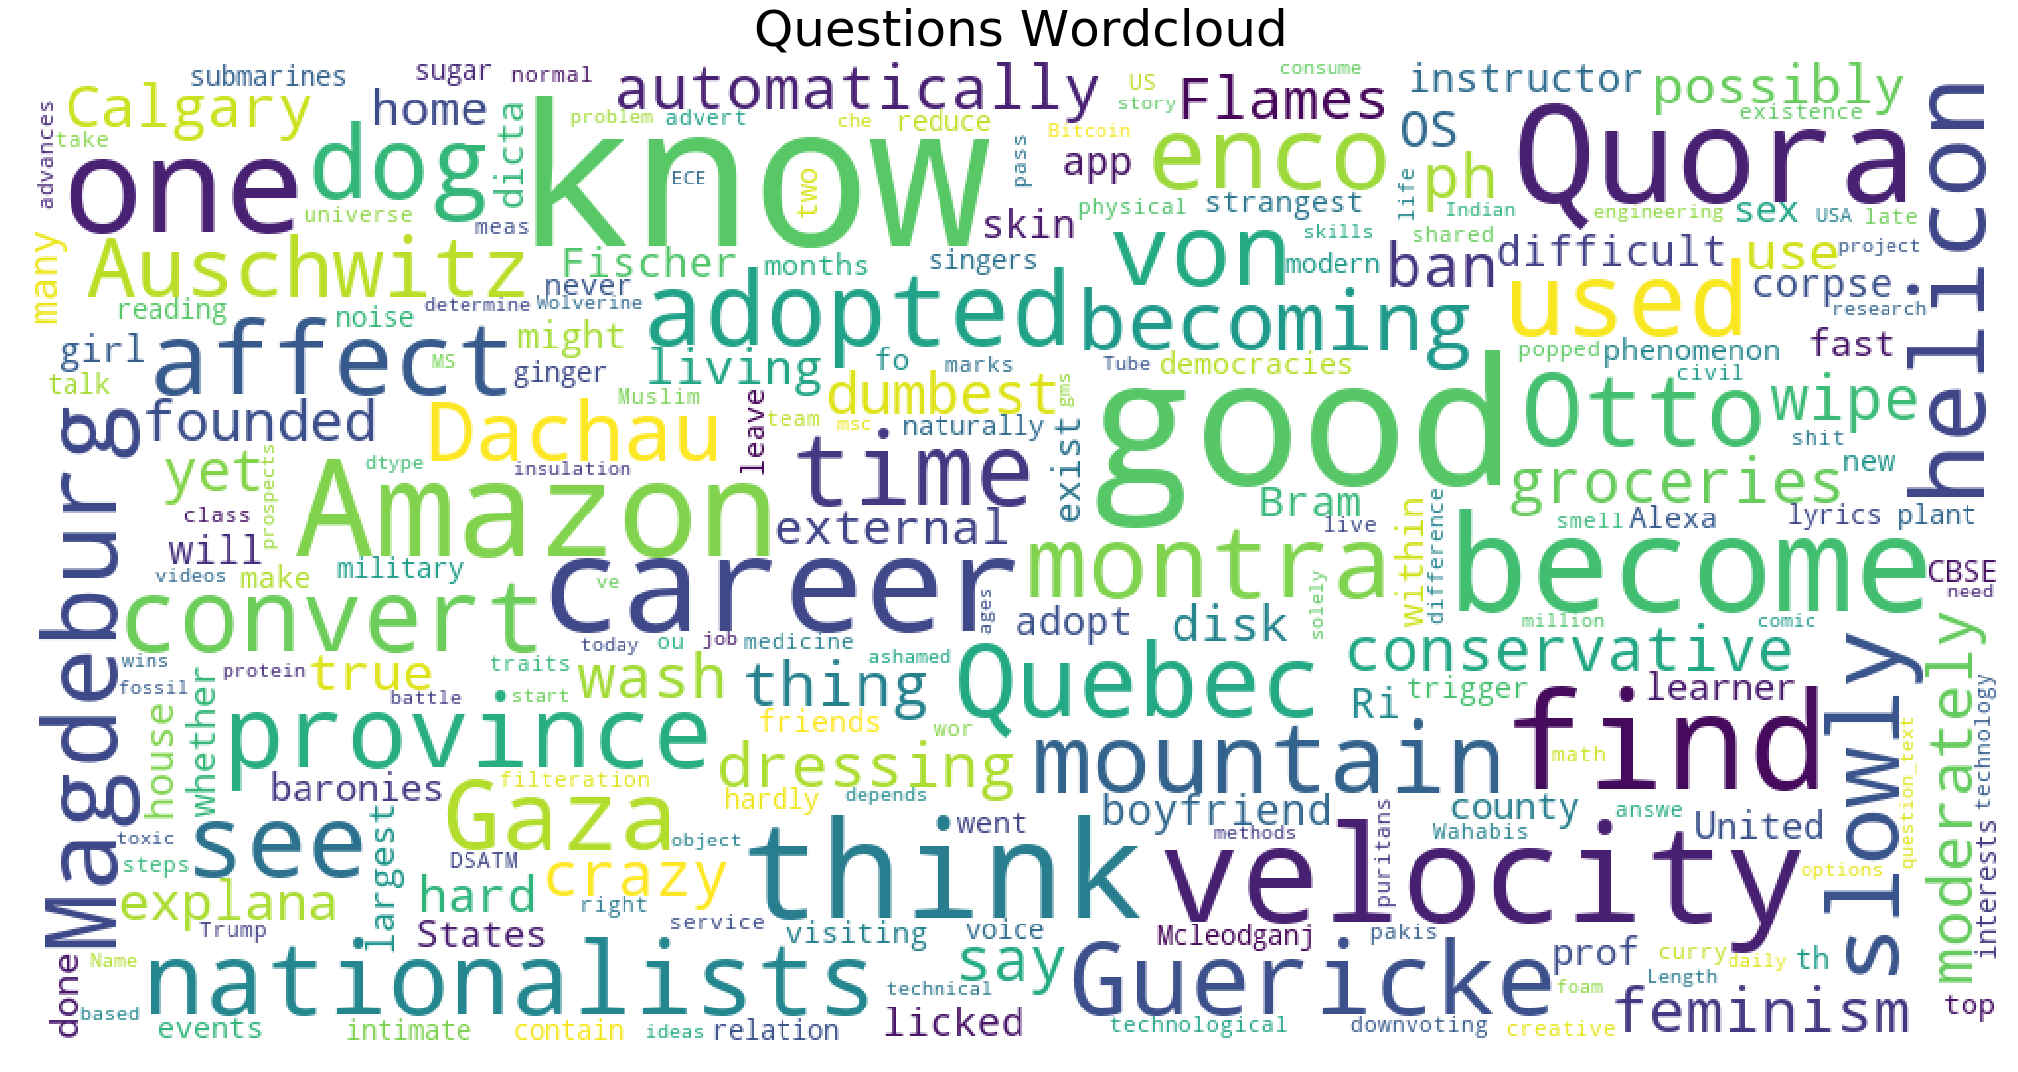

In [19]:
# Wordcloud
def plot_wordcloud(text, mask=None, max_words=300, max_font_size=100, figure_size=(30.0,15.0), 
                   title = None, title_size=50, image_color=False):

    wordcloud = WordCloud(background_color='white',
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    width=1000, 
                    height=500,
                    mask = mask)
    wordcloud.generate(str(text))
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()  
    
plot_wordcloud(train["question_text"], title="Questions Wordcloud")

In [20]:
# Word frequency plot
train1 = train[train["target"]==1]
train0 = train[train["target"]==0]

## custom function for ngram generation ##
def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(" ") if token != "" if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [" ".join(ngram) for ngram in ngrams]

## custom function for horizontal bar chart ##
def horizontal_bar_chart(df, color):
    trace = go.Bar(
        y=df["word"].values[::-1],
        x=df["wordcount"].values[::-1],
        showlegend=False,
        orientation = 'h',
        marker=dict(
            color=color,
        ),
    )
    return trace
## Get the bar chart from sincere questions ##
freq_dict = defaultdict(int)
for sent in train0["question_text"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(50), 'blue')

## Get the bar chart from insincere questions ##
freq_dict = defaultdict(int)
for sent in train1["question_text"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(50), 'blue')

# Creating two subplots
fig = tools.make_subplots(rows=1, cols=2, vertical_spacing=0.04,
                          subplot_titles=["Frequent words of sincere questions", 
                                          "Frequent words of insincere questions"])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig['layout'].update(height=1200, width=900, paper_bgcolor='rgb(233,233,233)', title="Word Count Plots")
py.iplot(fig, filename='word-plots')

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]



# <a href='#4'>4. Feature Engineering</a>

In [21]:
frames = [train,test]
data = pd.concat(frames, axis=0)

/home/claudio/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




In [22]:
data.head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0.0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0.0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0.0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0.0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0.0


In [23]:
data.tail()

,qid,question_text,target
56365,fffcf200619ef3426fc5,"Would I owe Queen Elizabeth II, if I could som...",NaN
56366,fffd424460c17be3f503,Is 6740 a good rank in Manipal online test?,NaN
56367,fffe18f21e5e070e55de,What would you like DC to do to make their mov...,NaN
56368,fffe4dd6bb7fd8fc1924,Do you think our system is fair? Consider fact...,NaN
56369,fffed08be2626f74b139,Why do all the stupid people I know tend to be...,NaN


In [24]:
# number of words 
data["num_words"]= data.question_text.apply(lambda x: len(str(x).split()))

In [25]:
# Number of unique words 
data["num_unique_words"] = data["question_text"].apply(lambda x: len(set(str(x).split())))

In [26]:
# length based features
data['len_text'] = data.question_text.apply(lambda x: len(str(x)))

In [27]:
# character length based features
data['len_char_question_text'] = data.question_text.apply(lambda x: 
                  len(''.join(set(str(x).replace(' ', '')))))


In [28]:
# word length based features
data['len_word_question_text'] = data.question_text.apply(lambda x: 
                                         len(str(x).split()))


In [29]:
# Number of stopwords 
data["num_stopwords"] = data["question_text"].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))

In [30]:
# common words in the dataset
data['common_words'] = data.apply(lambda x: 
                        len(set(str(x['question_text'])
                        .lower().split())), axis=1)
                                                                  

In [31]:
# Average length of the words 
data["len_mean_words"] = data["question_text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

In [32]:
data.head()

,qid,question_text,target,num_words,num_unique_words,len_text,len_char_question_text,len_word_question_text,num_stopwords,common_words,len_mean_words
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0.0,13,13,72,24,13,7,13,4.615385
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0.0,16,15,81,20,16,10,15,4.125000
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0.0,10,8,67,20,10,3,7,5.800000
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0.0,9,9,57,24,9,3,9,5.444444
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0.0,15,15,77,23,15,7,15,4.200000


In [33]:
fs_1 = ['num_words','num_unique_words','len_question_text', 'len_char_question_text', 
        'len_word_question_text','num_stopwords','common_words','len_mean_words']

## <a href='#4-1'>4.1 TF-IDF and SVD features</a>

Next features are created using TF-IDF and SVD methods.
TF-IDF stands for “Term Frequency — Inverse Data Frequency”. It is an approach to rescale the frequency of words by how often they appear in all documents. Term Frequency apply a score of the frequency of the word in the current corpus; Inverse Document Frequency apply a score of how rare the word is across the corpus. With tf-idf technique terms are weighted and so on with scores are highlighted words with useful information.

SVD stands for singular value decomposition and it is a feature decomposition method. It is largely used in NLP for the use of Latent Semantic Analysis (LSA).
It consists in a matrix decomposition for reducing a matrix to its constituent parts in order to make matrix calculations simpler. It finds a reduced dimensional representation of the document matrix with the least possible information.


In [34]:
tfv_data = TfidfVectorizer(min_df=3, 
                         max_features=None, 
                         strip_accents='unicode', 
                         analyzer='word', 
                         token_pattern=r'\w{1,}',
                         ngram_range=(1, 2), 
                         use_idf=1, 
                         smooth_idf=1, 
                         sublinear_tf=1,
                         stop_words='english')

In [35]:
data_tfidf = tfv_data.fit_transform(data.question_text.fillna(""))

In [36]:
svd_data = TruncatedSVD(n_components=180)

In [37]:
question_data_vectors = svd_data.fit_transform(data_tfidf)

In [38]:
data['skew_question_text_vec'] = [skew(x) for x in np.nan_to_num(question_data_vectors)]
data['kur_question_text_vec'] = [kurtosis(x) for x in np.nan_to_num(question_data_vectors)]

In [39]:
fs_2 = ['skew_question_text_vec', 'kur_question_text_vec']

In [40]:
del([tfv_data, data_tfidf,svd_data,question_data_vectors])

In [41]:
gc.collect()

7

## <a href='#4-2'>4.2 Word2Vec Embeddings</a>

The second step is to use word embedding with the goal to generate vectors encoding semantics: individual words are represented by vectors in a predefined vector space. Is used Word2vec methodology: it is a neural network that try to maximize the probability to see a word in a context window, the cosine similarity between two vectors. 

The last step is sentence embeddings, with this approach the goal is to represent more than single words by vectors and in this contest is used sent2vec. It's a simple but efficient unsupervised objective to train distributed representations of sentences. It can be thought of as an extension of FastText and word2vec to sentences. 


In [43]:
model1 = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

In [44]:
model2 = gensim.models.KeyedVectors.load_word2vec_format('wiki-news-300d-1M.vec', binary=False)

In [45]:
stop_words = set(stopwords.words('english'))

def sent2vec(s, model):  
    M = []
    words = word_tokenize(str(s).lower())
    for word in words:
        #It shouldn't be a stopword
        if word not in stop_words:
            #nor contain numbers
            if word.isalpha():
                #and be part of Word2Vec
                if word in model:
                    M.append(model[word])
    M = np.array(M)
    if len(M) > 0:
        v = M.sum(axis=0)
        return v / np.sqrt((v ** 2).sum())
    else:
        return model.get_vector('null')

In [46]:
w2v_qt1 = np.array([sent2vec(q, model1) 
                   for q in data.question_text])
w2v_qt2 = np.array([sent2vec(q, model2) 
                   for q in data.question_text])


data['cosine_distance'] = [cosine(x,y) for (x,y) in zip(w2v_qt1,w2v_qt2)]
data['cityblock_distance'] = [cityblock(x,y) for (x,y) in zip(w2v_qt1,w2v_qt2)]
data['jaccard_distance'] = [jaccard(x,y) for (x,y) in zip(w2v_qt1,w2v_qt2)]
data['canberra_distance'] = [canberra(x,y) for (x,y) in zip(w2v_qt1,w2v_qt2)]
data['euclidean_distance'] = [euclidean(x,y) for (x,y) in zip(w2v_qt1,w2v_qt2)]
data['minkowski_distance'] = [minkowski(x,y,3) for (x,y) in zip(w2v_qt1,w2v_qt2)]
data['braycurtis_distance'] = [braycurtis(x,y) for (x,y) in zip(w2v_qt1,w2v_qt2)]

fs_3 = ['cosine_distance', 'cityblock_distance', 
         'jaccard_distance', 'canberra_distance', 
         'euclidean_distance', 'minkowski_distance',
         'braycurtis_distance']

del([w2v_qt1, w2v_qt2, model1,model2])
gc.collect()

42

In [47]:
data.head()

,qid,question_text,target,num_words,num_unique_words,len_text,len_char_question_text,len_word_question_text,num_stopwords,common_words,len_mean_words,skew_question_text_vec,kur_question_text_vec,cosine_distance,cityblock_distance,jaccard_distance,canberra_distance,euclidean_distance,minkowski_distance,braycurtis_distance
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0.0,13,13,72,24,13,7,13,4.615385,8.041337,86.860846,0.958788,17.925303,1.0,219.527547,1.384766,0.683512,0.994693
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0.0,16,15,81,20,16,10,15,4.125000,2.955220,26.091650,1.044776,17.829639,1.0,222.955157,1.445528,0.756452,0.995997
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0.0,10,8,67,20,10,3,7,5.800000,1.598837,20.467338,0.975169,18.322012,1.0,221.682031,1.396545,0.686690,0.976666
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0.0,9,9,57,24,9,3,9,5.444444,4.716307,31.874782,0.974808,18.548790,1.0,219.227862,1.396287,0.676718,0.994800
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0.0,15,15,77,23,15,7,15,4.200000,0.230884,9.758606,0.998848,18.001902,1.0,209.244411,1.413398,0.736877,0.949207


In [48]:
data.shape

(1362492, 20)

# <a href='#5'>5. Logistic regression Baseline Model</a>

The baseline model without cross-validation shows a really good score, surely there is overfitting but in the same time I think the model has high potential to be really predictive!!!

In [49]:
y = train.iloc[:,2].values

In [55]:
columns = [3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]

In [56]:
X = data.iloc[0:1306122,columns].values

In [57]:
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.20, random_state=42)

In [58]:
import psutil
psutil.virtual_memory()

svmem(total=16724889600, available=9650941952, percent=42.3, used=6268125184, free=9512673280, active=5277171712, inactive=1543811072, buffers=47206400, cached=896884736, shared=510902272, slab=180363264)

In [68]:
logres = linear_model.LogisticRegression(C=0.1, solver='sag', max_iter=1000)

In [69]:
logres.fit(X_train, y_train)

/home/claudio/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='sag', tol=0.0001,
          verbose=0, warm_start=False)

In [70]:
lr_preds = logres.predict(X_test)
from sklearn.metrics import f1_score
F1_score = f1_score(y_test, lr_preds, average='weighted')
print("Logistic regression F1 score: %0.3f" % F1_score)

Logistic regression F1 score: 0.912
